### Выберите ряд из первого задания и постройте его модель GARCH. ###

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

from warnings import filterwarnings 
filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [5]:
series = pd.read_csv("daily-total-female-births-in-cal.csv").dropna().values[:, 1]

#### GARCH ####

In [14]:
pip install "arch==4.13"

  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)



In [15]:
from arch import arch_model

Сначала применим ARIMA к нашему временному ряду

In [12]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

best_aic, best_order, best_mdl = _get_best_model(series)

aic: 2452.86253 | order: (3, 1, 4)


Теперь применим GARCH

In [16]:
series = series[1:] - series[:-1]
series = series.astype(float)

Перед применением GARCH проверим ряд на стационарность

Results of Dickey-Fuller Test:
Test Statistic                -1.262518e+01
p-value                        1.547240e-23
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


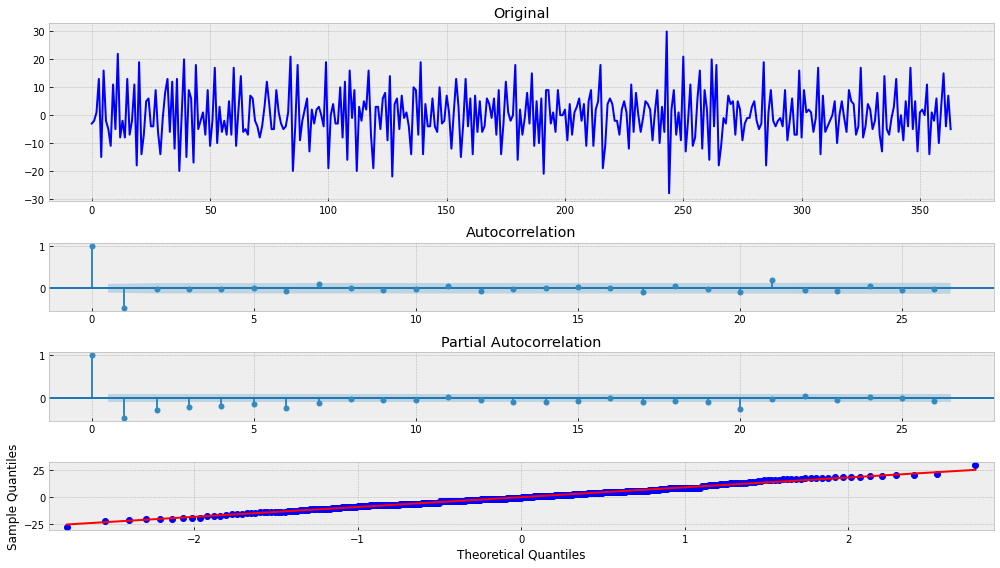

In [17]:
tsplot(series)

Ряд стационарен, можем применять модель GARCH

In [18]:
# Now we can fit the arch model using the best fit arima model parameters
p_, o_, q_ = best_order

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.009
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.009
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1314.29
Distribution:      Standardized Student's t   AIC:                           2650.58
Method:                  Maximum Likelihood   BIC:                           2693.44
                                              No. Observations:                  364
Date:                      Mon, Aug 09 2021   Df Residuals:                      353
Time:                              22:42:39   Df Model:                           11
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

Results of Dickey-Fuller Test:
Test Statistic                -1.262518e+01
p-value                        1.547240e-23
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


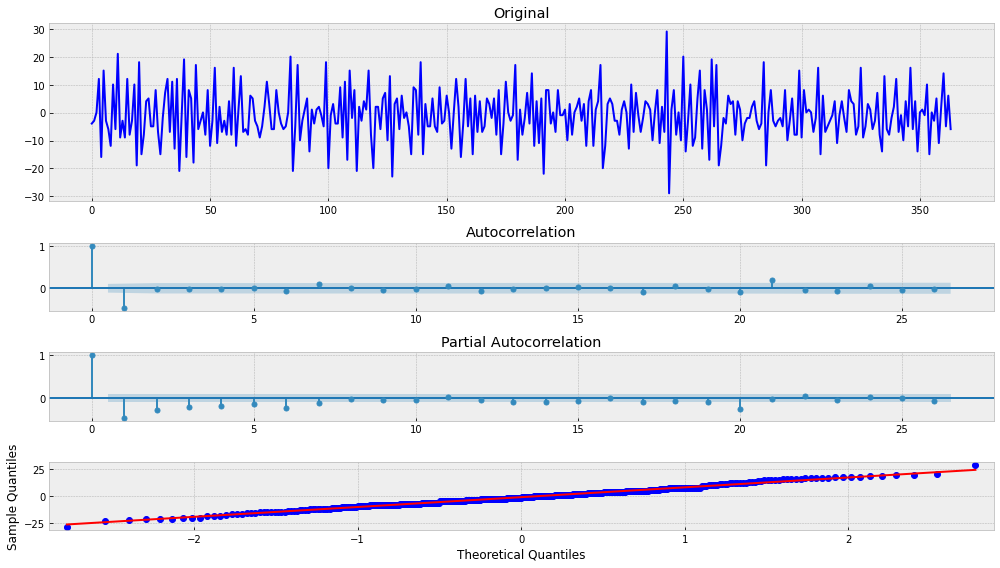

In [19]:
tsplot(res.resid)

Попробуем предсказать

In [20]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

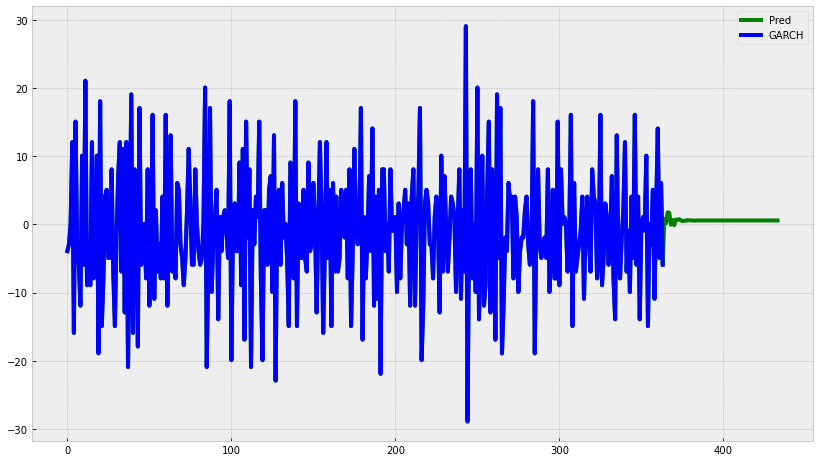

In [21]:
series_pred = predict(pd.Series(res.resid), 7, 70)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred')
    plt.plot(pd.Series(res.resid), color='blue', linewidth='4', label='GARCH')
    plt.legend()